# Machine Learning Engineering Capstone Project
#### In this Project i attemted to create a model that Could classify dog breed by giving a image of size `224x224` <br>
#### The Dataset that I used in this project is Provided freely by Stanford <br>
[Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/)
<br>
#### *the dataset contains `120` distinct catagories dogs breeds*
### Below is my attemt to creating a model that Could Classify this images and the create a TFLite Model to Deploy it to an Android app

In [ ]:
import tensorflow as tf
assert tf.__version__.startswith('2')

import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
tf.__version__

'2.4.0'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Check if all the images are at the correct location.

# !ls gdrive/MyDrive/Datasets/DOG_BREED/images/Images/

In [ ]:
image_dir = '/content/gdrive/MyDrive/Datasets/DOG_BREED/images/Images'

## Create Batches and Recsale the images.
Using ImageDataGenerator to rescale images 


In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 16541 images belonging to 120 classes.
Found 4080 images belonging to 120 classes.


In [ ]:
# Checking the batch Shapes.
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 120))

In [ ]:
# getting all the labels from and pasting them into a labels file for further refrence.

print (train_generator.class_indices)
labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'n02085620-Chihuahua': 0, 'n02085782-Japanese_spaniel': 1, 'n02085936-Maltese_dog': 2, 'n02086079-Pekinese': 3, 'n02086240-Shih-Tzu': 4, 'n02086646-Blenheim_spaniel': 5, 'n02086910-papillon': 6, 'n02087046-toy_terrier': 7, 'n02087394-Rhodesian_ridgeback': 8, 'n02088094-Afghan_hound': 9, 'n02088238-basset': 10, 'n02088364-beagle': 11, 'n02088466-bloodhound': 12, 'n02088632-bluetick': 13, 'n02089078-black-and-tan_coonhound': 14, 'n02089867-Walker_hound': 15, 'n02089973-English_foxhound': 16, 'n02090379-redbone': 17, 'n02090622-borzoi': 18, 'n02090721-Irish_wolfhound': 19, 'n02091032-Italian_greyhound': 20, 'n02091134-whippet': 21, 'n02091244-Ibizan_hound': 22, 'n02091467-Norwegian_elkhound': 23, 'n02091635-otterhound': 24, 'n02091831-Saluki': 25, 'n02092002-Scottish_deerhound': 26, 'n02092339-Weimaraner': 27, 'n02093256-Staffordshire_bullterrier': 28, 'n02093428-American_Staffordshire_terrier': 29, 'n02093647-Bedlington_terrier': 30, 'n02093754-Border_terrier': 31, 'n02093859-Kerry_blue

In [ ]:
!cat labels.txt

n02085620-Chihuahua
n02085782-Japanese_spaniel
n02085936-Maltese_dog
n02086079-Pekinese
n02086240-Shih-Tzu
n02086646-Blenheim_spaniel
n02086910-papillon
n02087046-toy_terrier
n02087394-Rhodesian_ridgeback
n02088094-Afghan_hound
n02088238-basset
n02088364-beagle
n02088466-bloodhound
n02088632-bluetick
n02089078-black-and-tan_coonhound
n02089867-Walker_hound
n02089973-English_foxhound
n02090379-redbone
n02090622-borzoi
n02090721-Irish_wolfhound
n02091032-Italian_greyhound
n02091134-whippet
n02091244-Ibizan_hound
n02091467-Norwegian_elkhound
n02091635-otterhound
n02091831-Saluki
n02092002-Scottish_deerhound
n02092339-Weimaraner
n02093256-Staffordshire_bullterrier
n02093428-American_Staffordshire_terrier
n02093647-Bedlington_terrier
n02093754-Border_terrier
n02093859-Kerry_blue_terrier
n02093991-Irish_terrier
n02094114-Norfolk_terrier
n02094258-Norwich_terrier
n02094433-Yorkshire_terrier
n02095314-wire-haired_fox_terrier
n02095570-Lakeland_terrier
n02095889-Sealyham_terrier
n02096051-Aired

## Implementing Transfer Learning
Base model from pre-trained convolutional networks
- MobileNetV2  <br>

#### Why did I choose MobileNetV2?
1. The Main Goal From The Begining Was To Implement the Model to Deployed using TFLite on an Android App.
2. As I tried Implementing multiple models which were available as an option,
I tried to implementing Inception v3 Model it turned out as it was said pretty heavy `80mb~`where as MobileNetV2 always was around `25mb`

In [ ]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)    # <-- X-axis, Y-axis and Z-[corresponding to RGB]

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False    
# setting the Trainable to false so that we don't mess up the pretrained weights

In [ ]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.GlobalAveragePooling2D(),

  tf.keras.layers.Dense(120, activation='softmax')
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 120)               3960      
Total params: 2,630,616
Trainable params: 372,632
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


In [ ]:
callbacks = [
             tf.keras.callbacks.EarlyStopping(
                 monitor='val_loss', patience = 15,
                 min_delta=0.001
             )
]

In [ ]:
%%time

epochs = 25

history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator), 
                    epochs=epochs, 
                    batch_size=32,
                    callbacks=callbacks,
                    validation_data=val_generator, 
                    validation_steps=len(val_generator))

## Evaluation the Model

#### Is the output better than you expected :) ? Or worse :( ? Provide at least three possible points of improvement for your algorithm.

<br>
When i started working on the project, i knew this is going to take a really long amount of time.<br>
1.   When i first ran the model it did not perform as well as i expected it to be `25 epochs`. it took around 4 hours to train.
<br>
2.   After Being aware with the first attempts  result, I tried being greedy and Pushed the ephocs to `50 epochs` to atleast get a bit of overfitting. that lead to the notebook terminating overnight as i was asleep 8hrs  wasted.<br>
3.  The result could be improved by using a diffrent pretrained model like Inception V3 but that may lead increased app size & the by data augmentation which may also lead to Increased Traning time.


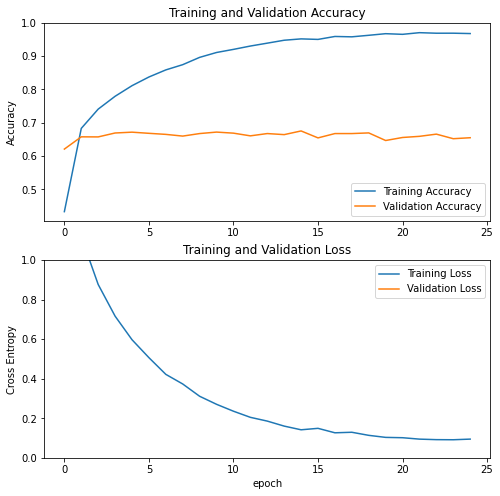

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tuning the pretrained model


In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

In [ ]:
history_fine = model.fit(train_generator, 
                         steps_per_epoch=len(train_generator), 
                         epochs=5, 
                         validation_data=val_generator, 
                         validation_steps=len(val_generator))

Epoch 1/5
258/258 [==============================] - 106s 411ms/step - loss: 1.4923 - accuracy: 0.6918 - val_loss: 2.3518 - val_accuracy: 0.6616
Epoch 2/5
258/258 [==============================] - 106s 409ms/step - loss: 0.7244 - accuracy: 0.7973 - val_loss: 2.3455 - val_accuracy: 0.6586
Epoch 3/5
258/258 [==============================] - 107s 414ms/step - loss: 0.4949 - accuracy: 0.8482 - val_loss: 2.1940 - val_accuracy: 0.6545
Epoch 4/5
258/258 [==============================] - 108s 418ms/step - loss: 0.3597 - accuracy: 0.8854 - val_loss: 2.1837 - val_accuracy: 0.6584
Epoch 5/5
258/258 [==============================] - 107s 413ms/step - loss: 0.2805 - accuracy: 0.9051 - val_loss: 2.2318 - val_accuracy: 0.6564


## Convert to TFLite

In [ ]:
saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: save/fine_tuning/assets


## Result On Android App
Demo Video of the app: [Watch](https://youtu.be/KiuBtjdRvHg)
### **Below are some of the example image showing `Dog Breed Detector App` classifieng images of dogs**
<br><br>
<img src='https://raw.githubusercontent.com/vaibhavCodian/Dog-Breed-Detector-capstone/master/screenshots/ss4.png' width=330px>
<img src='https://raw.githubusercontent.com/vaibhavCodian/Dog-Breed-Detector-capstone/master/screenshots/ss2.png' width=330px>
<img src='https://raw.githubusercontent.com/vaibhavCodian/Dog-Breed-Detector-capstone/master/screenshots/ss3.png' width=330px><br>
<img src='https://raw.githubusercontent.com/vaibhavCodian/Dog-Breed-Detector-capstone/master/screenshots/ss1.png' width=500px>
<img src='https://raw.githubusercontent.com/vaibhavCodian/Dog-Breed-Detector-capstone/master/screenshots/ss5.png' width=500px>


<!-- video link -->
